In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
train_df = pd.read_csv('./UTKFace/train_split.csv')

test_df_final = pd.read_csv('./UTKFace/test_split.csv')

valid_df = pd.read_csv('./UTKFace/valid_split.csv')

augmented_train_df = pd.read_csv('./UTKFace/augmented_train_split.csv')

combined_train_df = pd.read_csv('./UTKFace/combined_train_split.csv')

C:\Users\anoop\AppData\Local\Temp\ipykernel_7984\3756340081.py:9: DtypeWarning: Columns (3,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_train_df = pd.read_csv('./UTKFace/combined_train_split.csv')


In [3]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

In [4]:
class DataGenerator(Sequence):
    def __init__(self, df, directory, batch_size=32, dim=(224, 224), n_channels=3, shuffle=True, use_augmented=False):
        self.df = df.copy()
        self.directory = directory
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.use_augmented = use_augmented
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, row in enumerate(batch_df.itertuples()):
            
            if self.use_augmented and 'original_' in row.file_name:
                original_part = row.file_name.split('original_')[1]
                file_path = os.path.join(self.directory, row.combined_category, "output", row.combined_category + '_original_' + original_part)
            
            elif self.use_augmented:
                file_path = os.path.join(self.directory, row.combined_category, row.file_name)
            
            else:
                file_path = os.path.join("./UTKFace/", row.file_name)

            img = cv2.imread(file_path)
            if img is None:
                print(f"Failed to load image at path: {file_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.dim)
            X[i, ] = img / 255.0  
            y[i] = row.age

        return X, y

In [5]:
age_mapping = {
    "Children" : 0,
    "Teenagers" : 1,
    "Young Adults" : 2,
    "Adults" : 3,
    "Seniors" : 4
}

race_mapping = {
    "White" : 0,
    "Black" : 1,
    "Asian" : 2,
    "Indian" : 3,
    "Others" : 4
}

gender_mapping = {
    "Male" : 0,
    "Female" : 1
}

reverse_age_mapping = {v:k for k,v in age_mapping.items()}
reverse_race_mapping = {v:k for k,v in race_mapping.items()}
reverse_gender_mapping = {v:k for k,v in gender_mapping.items()}

In [6]:
directory_path = "./UTKFace/"
train_images_path = './UTKFace/train/'

In [7]:
train_generator = DataGenerator(df=combined_train_df, directory=train_images_path, batch_size=32, dim=(224, 224), n_channels=3, shuffle=True, use_augmented=True)
validation_generator = DataGenerator(df=valid_df, directory=directory_path, batch_size=32, dim=(224, 224), n_channels=3, shuffle=False, use_augmented=False)
test_generator = DataGenerator(df=test_df_final, directory=directory_path, batch_size=32, dim=(224, 224), n_channels=3, shuffle=False, use_augmented=False)

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import mean, square, var
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    SS_res =  mean(square(y_true - y_pred))  
    SS_tot = var(y_true)
    return (1 - SS_res/(SS_tot + K.epsilon()))



base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)




predictions = Dense(1, activation="linear")(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse", metrics=[r_squared])


model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)

                                                                                                  
 block_6_depthwise (Depthwi  (None, 14, 14, 192)          1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_p

                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_

 block_13_expand (Conv2D)    (None, 14, 14, 576)          55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 14, 14, 576)          2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
          

 block_16_expand_relu (ReLU  (None, 7, 7, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)     

In [9]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    verbose=1)

Epoch 1/5


2481/2481 [==============================] - 2368s 950ms/step - loss: 322.3823 - r_squared: 0.3940 - val_loss: 159.7791 - val_r_squared: 0.5599
Epoch 2/5
2481/2481 [==============================] - 2114s 852ms/step - loss: 182.3756 - r_squared: 0.6531 - val_loss: 153.5605 - val_r_squared: 0.5765
Epoch 3/5
2481/2481 [==============================] - 2058s 829ms/step - loss: 166.1496 - r_squared: 0.6854 - val_loss: 153.2415 - val_r_squared: 0.5749
Epoch 4/5
2481/2481 [==============================] - 2092s 843ms/step - loss: 157.1307 - r_squared: 0.7004 - val_loss: 153.6070 - val_r_squared: 0.5753
Epoch 5/5
2481/2481 [==============================] - 2099s 846ms/step - loss: 149.6130 - r_squared: 0.7141 - val_loss: 149.7428 - val_r_squared: 0.5847


*  0.560 to 0.585 => model performance improves and is able to explain the variance in unseen data

In [10]:
test_loss, test_r_squared = model.evaluate(test_generator, verbose=1)
print(f"Test Loss (MSE): {test_loss:.2f}")
print(f"Test R-squared: {test_r_squared:.2f}")

74/74 [==============================] - 61s 823ms/step - loss: 144.9792 - r_squared: 0.6085
Test Loss (MSE): 144.98
Test R-squared: 0.61


In [11]:
y_pred = model.predict(test_generator)
y_true = test_df_final['age'].values[:len(y_pred)]

74/74 [==============================] - 62s 799ms/step


In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 8.87


In [1]:
from IPython.display import HTML
HTML('<img src="./giphy4.gif">')

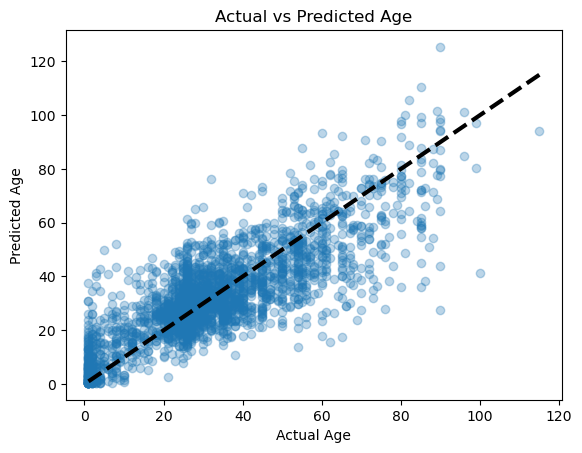

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
plt.show()

In [1]:
from IPython.display import HTML
HTML('<img src="./giphy8.gif">')